In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##The T-maze environment

The TMazeEnv1 environment represents a T-shaped maze where an agent (represented as a mouse) can navigate. Here's a description of the maze environment:

The maze is represented as a 15x15 grid, with walls and open spaces.
The mouse (agent) is initially placed at a specific location within the maze (specified as (mouse_row, mouse_col)).


The mouse can take actions to move in different directions: straight, left, or right. These actions are represented as 0, 1, and 2, respectively.


The goal of the mouse is to reach either the leftmost cell in the second row ((1, 0)) or the rightmost cell in the second row ((1, 14)). These cells act as final reward locations.


The mouse receives rewards based on its current position and the presence of cues and the final reward locations.


Cues are randomly placed in the maze, either on the left side or the right side. The number of cues on each side is specified as n_cues_left and n_cues_right. The presence of cues affects the rewards obtained by the mouse.
If the number of cues on the left side is greater than the number of cues on the right side, the mouse receives a positive reward for cues on the left side and a negative reward for cues on the right side. If the number of cues on the right side is greater, the rewards are reversed.


The mouse can see the cues in the cells below its current position. If a cue is detected, the mouse receives the associated reward.


The maze is visualized using matplotlib, with the mouse, cues, and final reward locations displayed as different symbols on the grid.


Our hypothesis is that as the complexity of the task increases, that is the difference between number of cues on the left and right is decreased,the task would become harder.



In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
class TMazeEnv1(gym.Env):
    def __init__(self,rat=(14,7)):
        self.grid = np.ones((15, 15), dtype=float)
        self.grid[:, :6] = 0
        self.grid[:, 9:] = 0
        self.grid[:3, :] = 1
        self.action_space = spaces.Discrete(3)  # 0: straight, 1: left, 2: right
     
        self.observation_space = spaces.Discrete(3)  # 0: no cue, 1: cue on the left, 2: cue on the right
        #episode done flag
        self.done=False
        self.current_state = ()
        self.previous_state=()#to reestore the previous state in the render
        self.valid_actions=[]#contains all possible valid actions
        self.reward_loc = None#to assign a cell in the grid to be the reward location
        self.cue_loc_r=[]#to assign grid in the cell to be cue location
        self.cue_loc_l=[]
        #no of cues on the right or left
        self.n_cues_right=0
        self.n_cues_left=0
        #assign cue and final reward values
        self.cue_reward_l=0
        self.cue_reward_r=0
        self.final_reward=5
        self.total_reward=0
        self.reward_flag=False
        #observation corridor and obervation reward
        self.obs_corridor_r=None
        self.obs_corridor_l=None
        self.obs_reward=None
        #valid actions aat decision point
        self.valid_action_decision=[]
        self.free_cells = [(r, 7) for r in range(1, 15)] + [(1, c) for c in range(15)]
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        
        self.reset(rat,self.n_cues_left,self.n_cues_right)
    def valid_actions(self):
        rat_row, rat_col = self.current_state
        self.valid_action_corridor=0
        self.valid_action_decision=[1,2]
        self.valid_action_left=1
        self.valid_action_right=2
        
     
       
        return self.valid_actions
    def get_state_matrix(self):
        state_matrix = np.copy(self.grid[3:15, 7])
        return state_matrix   
        
    def reset(self,rat,n_cues_right,n_cues_left):
            
            self.rat = rat
            self.grid = np.ones((15, 15), dtype=float)
            self.grid[:, :6] = 0
            self.grid[:, 9:] = 0
            self.grid[:3, :] = 1
            #reset rewards  
           
            
            self.total_reward=0
            self.reward_flag=False

            nrows, ncols = self.grid.shape
            row, col = rat
            self.current_state = (row, col)
            self.previous_state=(0,0)
            self.n_cues_right = n_cues_right
            self.n_cues_left = n_cues_left
            self.cue_loc_r = []
            self.cue_loc_l = []
            #if the no of cues is greater on the left than right then thats where the ultimate reward is
            if  self.n_cues_left>self.n_cues_right:
                self.reward_loc=[1,0]
               #cues on the left are assigned a positive reward
                self.cue_reward_l=1
                self.cue_reward_r=-1
            else:
                self.reward_loc=[1,14]
                #cues on the right are assigned a positive reward
                self.cue_reward_l=-1
                self.cue_reward_r=+1
            self.valid_cells_rows_l = random.sample(range(3, 15), self.n_cues_left)
            self.cue_loc_l= [(r, 6) for r in self.valid_cells_rows_l]
            self.valid_cells_rows_r = random.sample(range(3, 15), self.n_cues_right)
            self.cue_loc_r= [(r, 8) for r in self.valid_cells_rows_r]
                   
           

           


    def get_reward(self):
        rat_row, rat_col = self.current_state
        self.total_reward = 0
        if rat_row>=2 and rat_row<15:#if rat is in corridor
         for i in range(len(self.cue_loc_l)):#go over the list of cue locations on left and add rewrad
              cue_l_row,cue_l_col=self.cue_loc_l[i]       
              if cue_l_row-rat_row == 1:#sees reward to the left
                self.total_reward+=self.cue_reward_l

         for i in range(len(self.cue_loc_r)):#go over the list of cue locations on left and add rewrad
              cue_r_row,cue_r_col=self.cue_loc_r[i]       
              if cue_r_row-rat_row == 1:#sees reward to the right
                self.total_reward+=self.cue_reward_r
        
        if rat_row == 1 and rat_col == 0:
            self.total_reward += self.final_reward
            self.reward_flag=True
        elif rat_row == 1 and rat_col == 14:
            self.total_reward += self.final_reward
            self.reward_flag=True
        return self.total_reward

 
    def step(self, action):
        row, col = self.current_state
        row_prev=0
        col_prev=0
        if row==2 and col==7:
              row_prev=2
              col_prev=7
            
              
           
              if action==1:
                
                col-=1
                row-=1
               
                
              if action==2:
                
                col+=1
                row-=1
                
              if action==0:
                print("invalid action")
 

             
        elif row==1 and 0<col<=7:
            
            col-=1 
            col_prev=col+1 
            row_prev=1
            
        elif row==1 and 7<=col<15:
            
            col+=1 
            col_prev=col-1
            row_prev=1
                      
        elif col==7 and 1<=row<=14:
            
            row -= 1
            row_prev=row+1
            col_prev=7
            
      
        self.previous_state=(row_prev,col_prev)
        self.current_state = (row, col)
        self.done = False
        reward = self.get_reward()

        if self.current_state==(1,0) or   self.current_state==(1,14):
            self.done = True

        return self.grid, self.current_state[0], self.current_state[1], reward, self.done  #return observation, reward, done, {}

        
        
        
    def render(self, mode='human'):
        
        row, col = self.current_state
        row_prev,col_prev=self.previous_state
        self.grid[row,col]=0#rat
        self.grid[row_prev,col_prev]=1
        row_reward,column_reward=self.reward_loc
        self.grid[row_reward,column_reward]=0.3#reward cell
        for i in range(len(self.cue_loc_l)):#go over the list of cue locations on left and add rewrad
              cur_l_row,cue_l_col=self.cue_loc_l[i]        
              self.grid[cur_l_row,cue_l_col]=0.7

        for i in range(len(self.cue_loc_r)):#go over the list of cue locations on left and add rewrad
              cur_r_row,cue_r_col=self.cue_loc_r[i]        
              self.grid[cur_r_row,cue_r_col]=0.7

            
        plt.imshow(self.grid, cmap='gray')
        plt.axis('off')
        plt.savefig('maze_image.png')
        plt.show()
        




In [ ]:
from gym.envs.registration import register


In [ ]:
register(
    id='TMaze-v1',
    entry_point='tmaze_env:TMazeEnv1',  # Replace 'custom_env' with the name of the file containing the TMazeEnv class
)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment TMaze-v1
  logger.warn(f"Overriding environment {spec.id}")


# Lets first initialize a random agent and render the environment

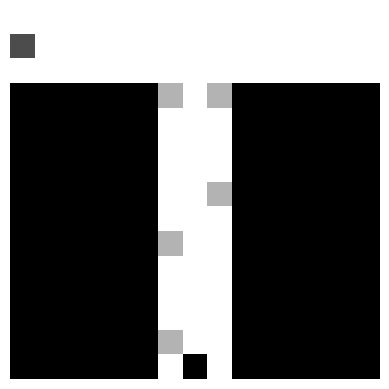

Row: 13 Col: 7 Reward: 0


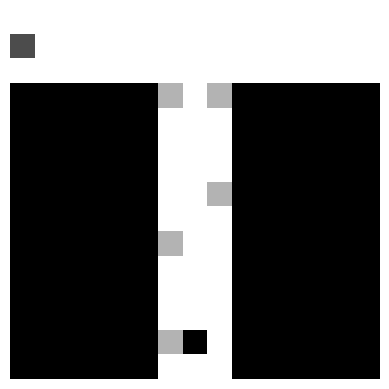

Row: 12 Col: 7 Reward: 1


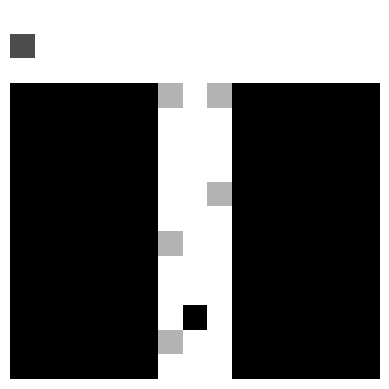

Row: 11 Col: 7 Reward: 0


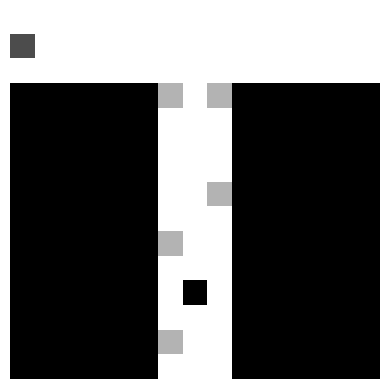

Row: 10 Col: 7 Reward: 0


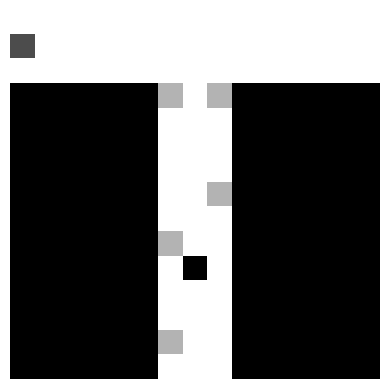

Row: 9 Col: 7 Reward: 0


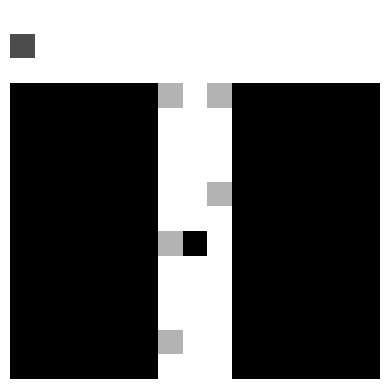

Row: 8 Col: 7 Reward: 1


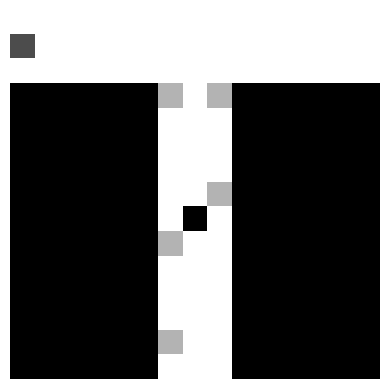

Row: 7 Col: 7 Reward: 0


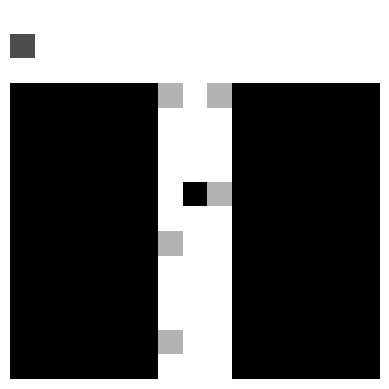

Row: 6 Col: 7 Reward: -1


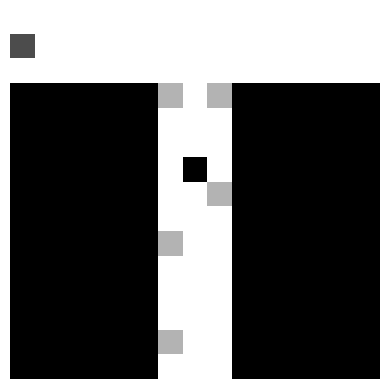

Row: 5 Col: 7 Reward: 0


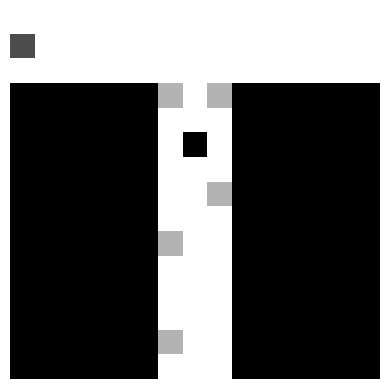

Row: 4 Col: 7 Reward: 0


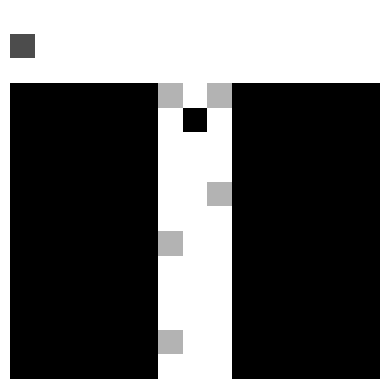

Row: 3 Col: 7 Reward: 0


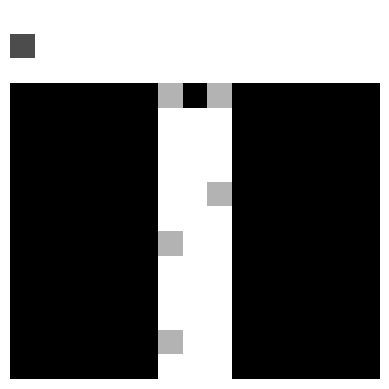

Row: 2 Col: 7 Reward: 0


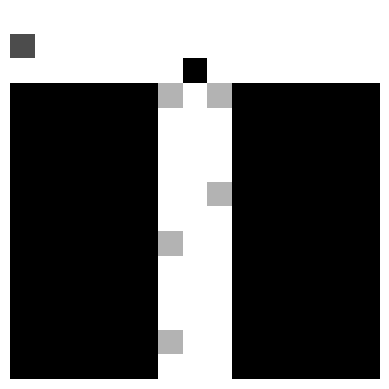

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


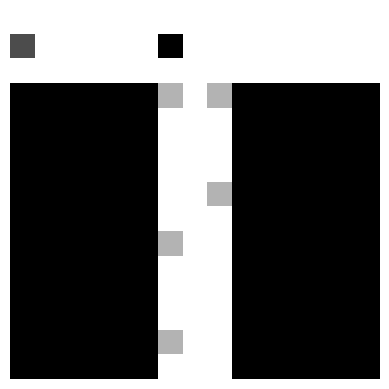

Row: 1 Col: 5 Reward: 0


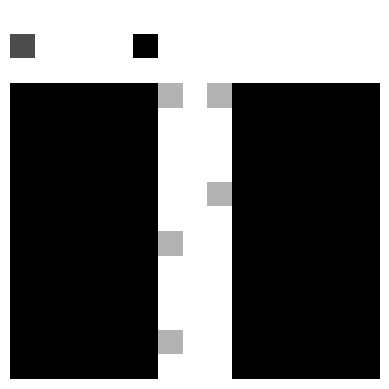

Row: 1 Col: 4 Reward: 0


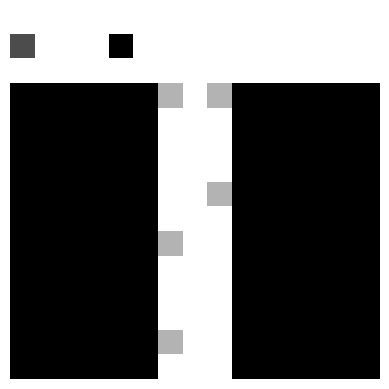

Row: 1 Col: 3 Reward: 0


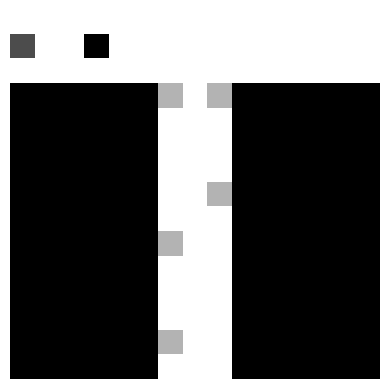

Row: 1 Col: 2 Reward: 0


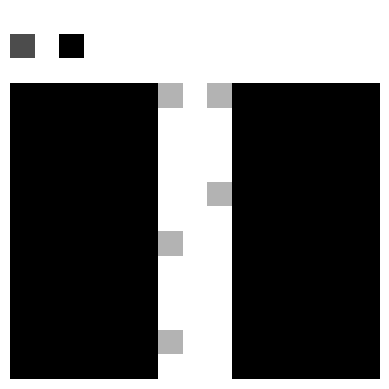

Row: 1 Col: 1 Reward: 0


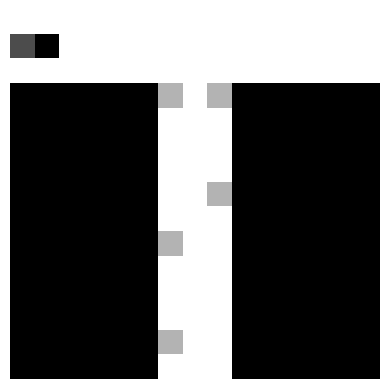

Row: 1 Col: 0 Reward: 5
Episode 1 completed.
Final Reward: 5


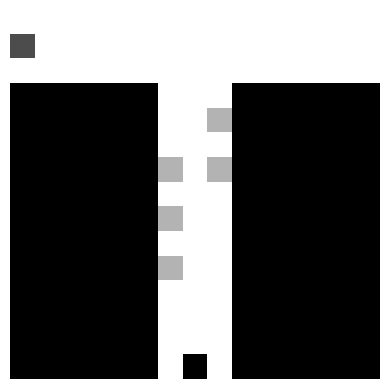

Row: 13 Col: 7 Reward: 0


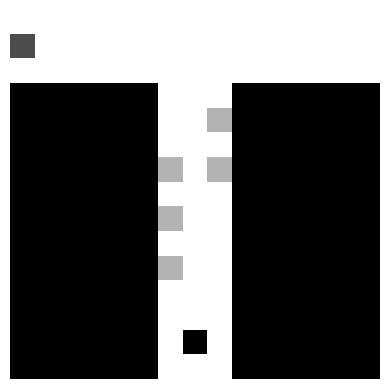

Row: 12 Col: 7 Reward: 0


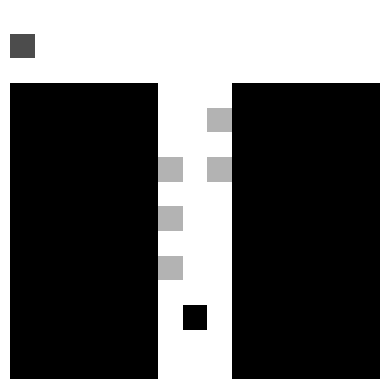

Row: 11 Col: 7 Reward: 0


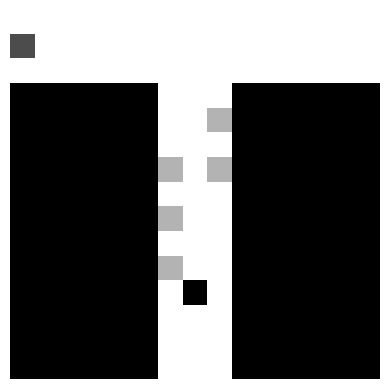

Row: 10 Col: 7 Reward: 0


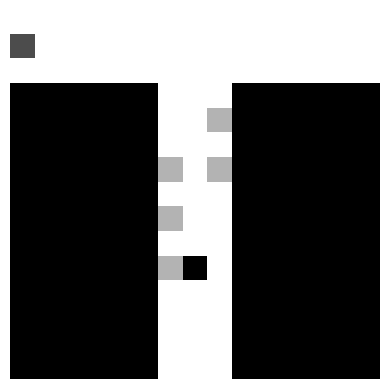

Row: 9 Col: 7 Reward: 1


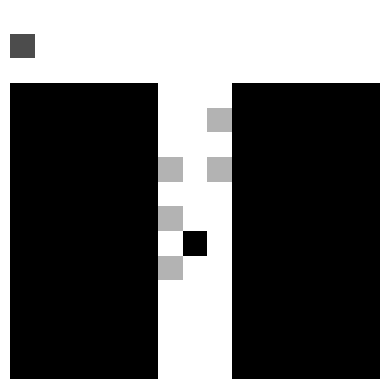

Row: 8 Col: 7 Reward: 0


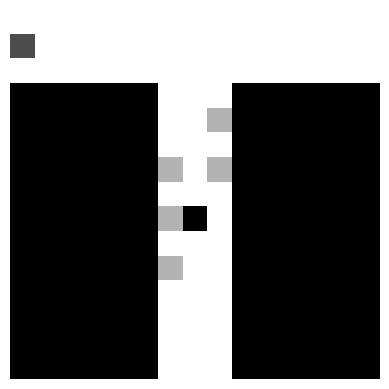

Row: 7 Col: 7 Reward: 1


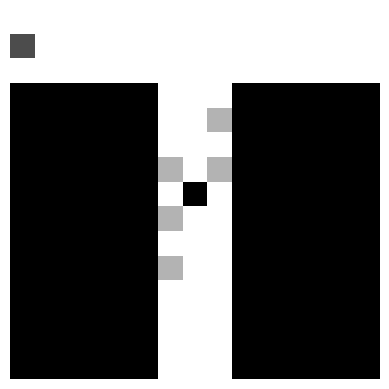

Row: 6 Col: 7 Reward: 0


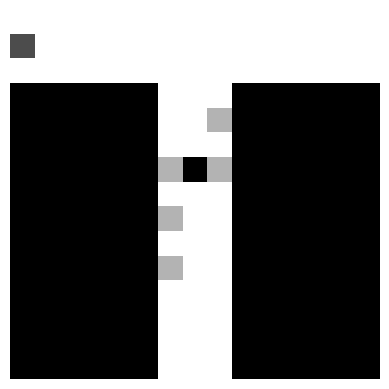

Row: 5 Col: 7 Reward: 0


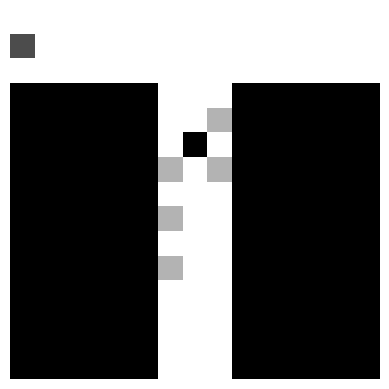

Row: 4 Col: 7 Reward: 0


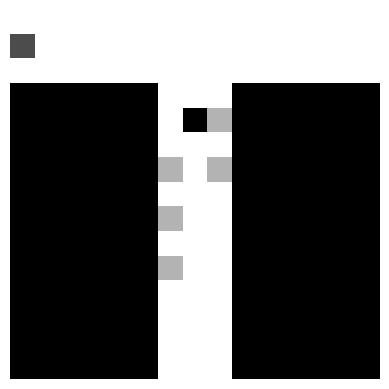

Row: 3 Col: 7 Reward: -1


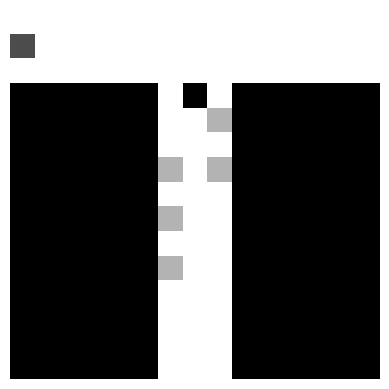

Row: 2 Col: 7 Reward: 0


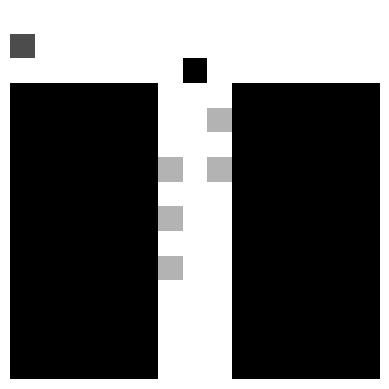

Taking decision
Action: 2
Row: 1 Col: 8 Reward: 0


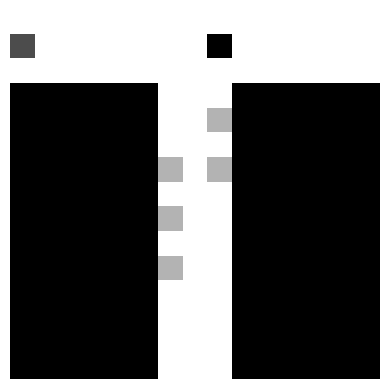

Row: 1 Col: 9 Reward: 0


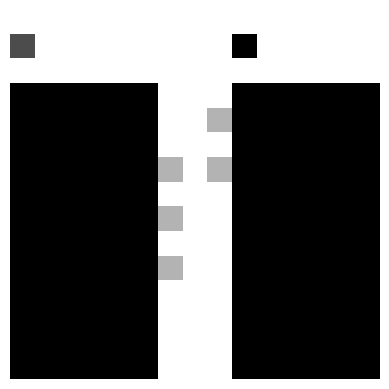

Row: 1 Col: 10 Reward: 0


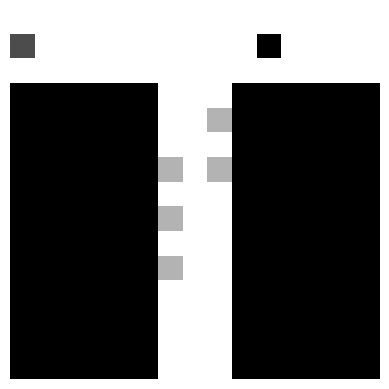

Row: 1 Col: 11 Reward: 0


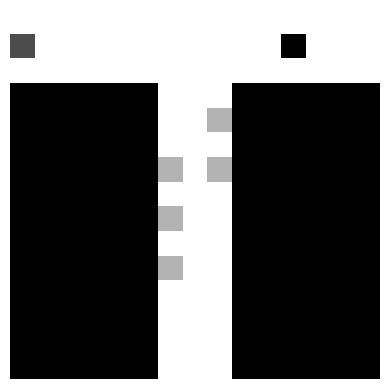

Row: 1 Col: 12 Reward: 0


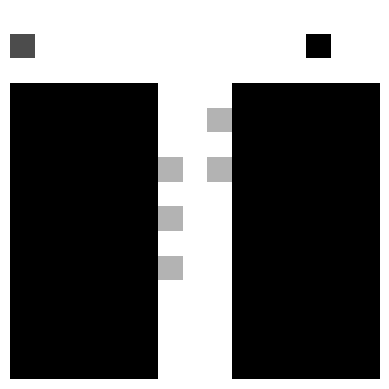

Row: 1 Col: 13 Reward: 0


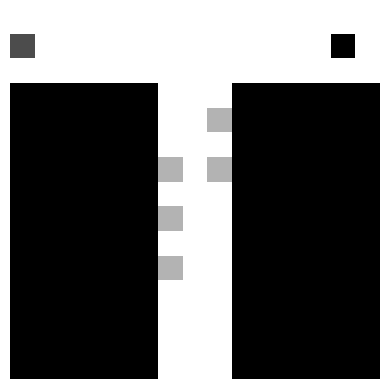

Row: 1 Col: 14 Reward: 5
Episode 2 completed.
Final Reward: 5


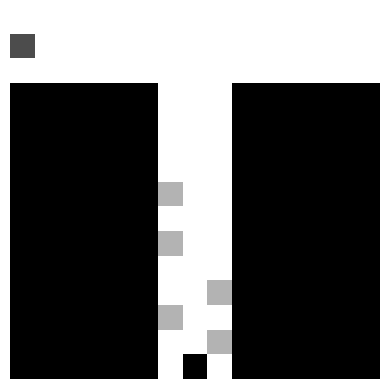

Row: 13 Col: 7 Reward: 0


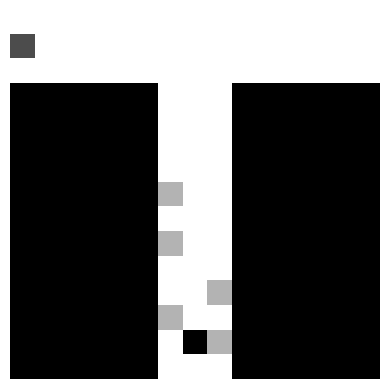

Row: 12 Col: 7 Reward: -1


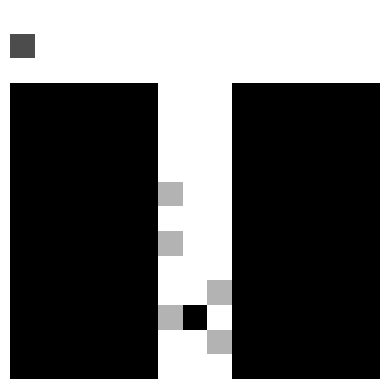

Row: 11 Col: 7 Reward: 1


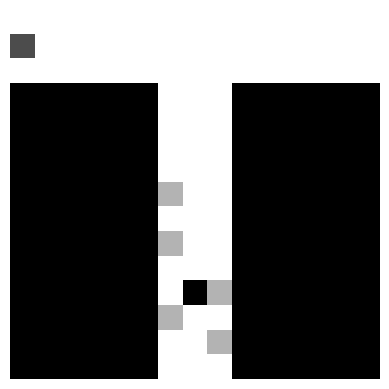

Row: 10 Col: 7 Reward: -1


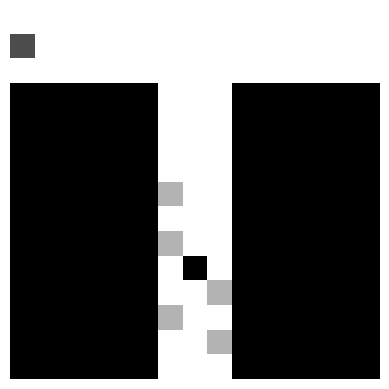

Row: 9 Col: 7 Reward: 0


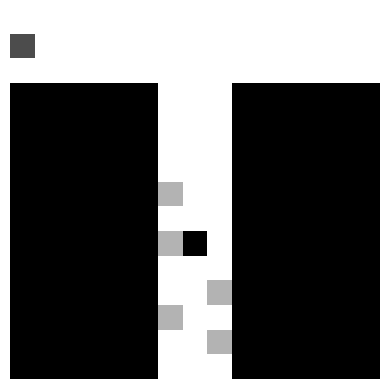

Row: 8 Col: 7 Reward: 1


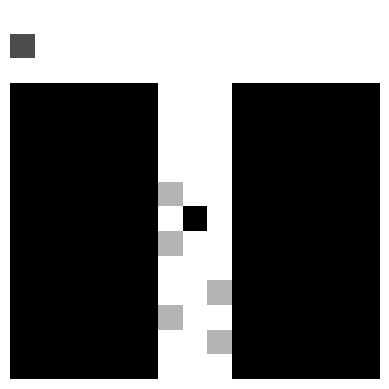

Row: 7 Col: 7 Reward: 0


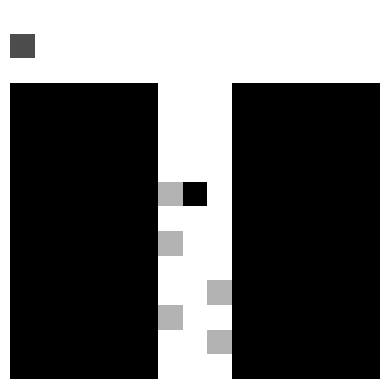

Row: 6 Col: 7 Reward: 1


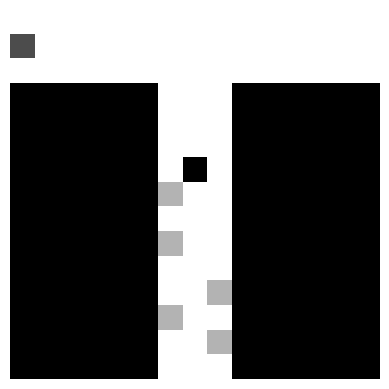

Row: 5 Col: 7 Reward: 0


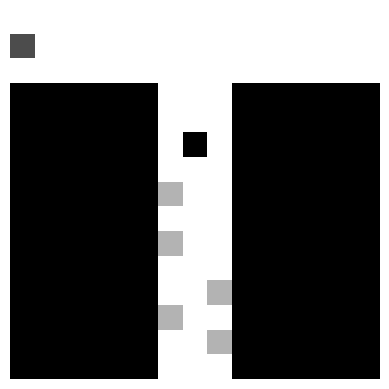

Row: 4 Col: 7 Reward: 0


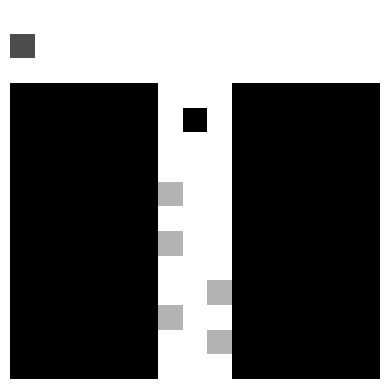

Row: 3 Col: 7 Reward: 0


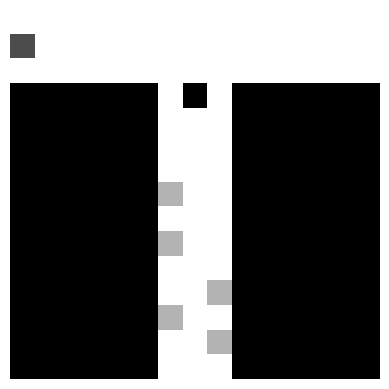

Row: 2 Col: 7 Reward: 0


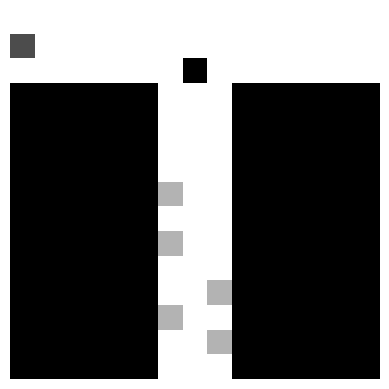

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


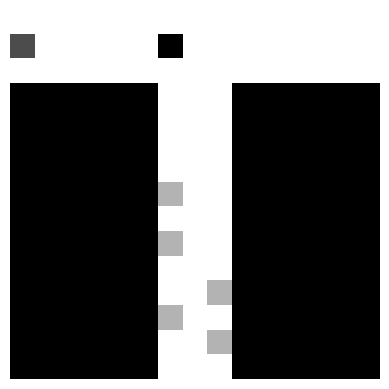

Row: 1 Col: 5 Reward: 0


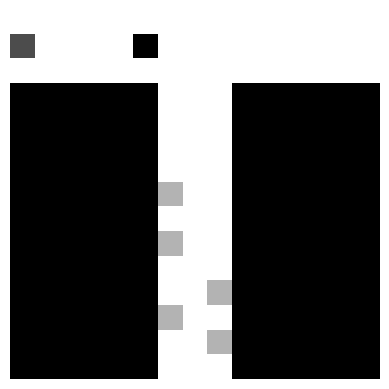

Row: 1 Col: 4 Reward: 0


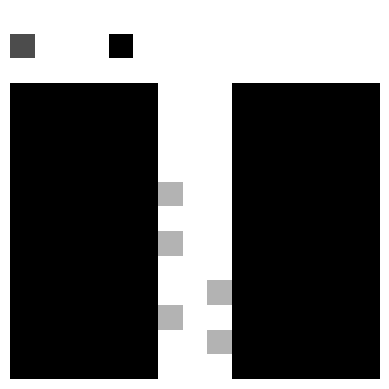

Row: 1 Col: 3 Reward: 0


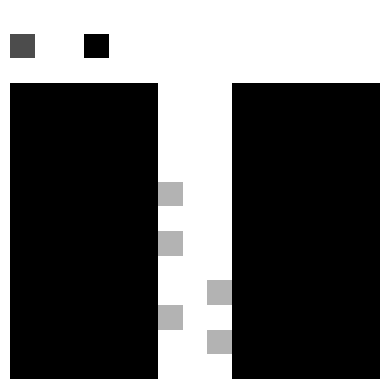

Row: 1 Col: 2 Reward: 0


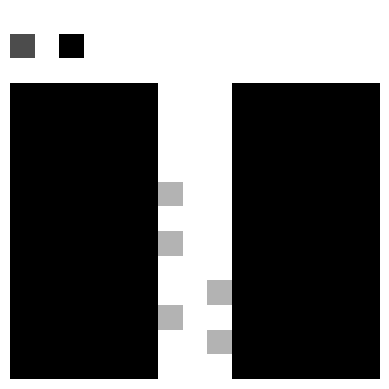

Row: 1 Col: 1 Reward: 0


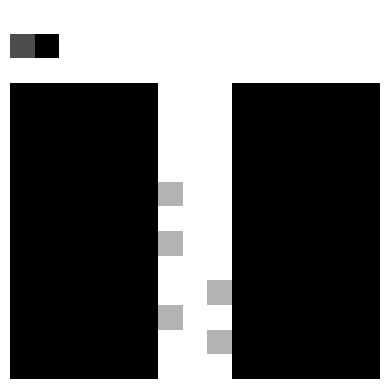

Row: 1 Col: 0 Reward: 5
Episode 3 completed.
Final Reward: 5


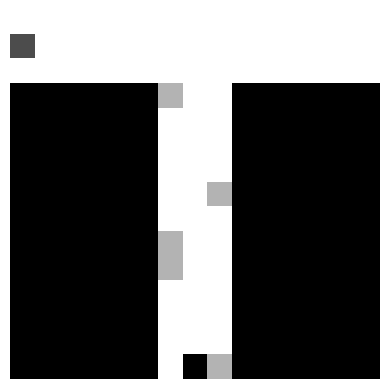

Row: 13 Col: 7 Reward: -1


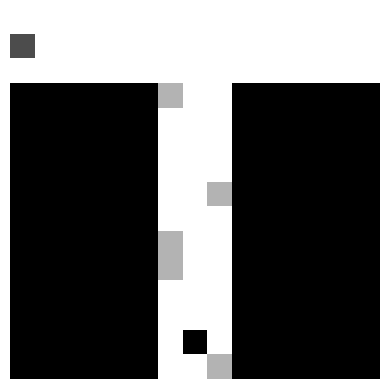

Row: 12 Col: 7 Reward: 0


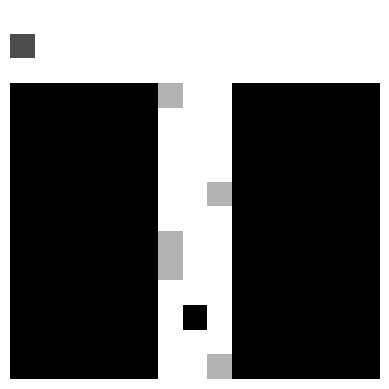

Row: 11 Col: 7 Reward: 0


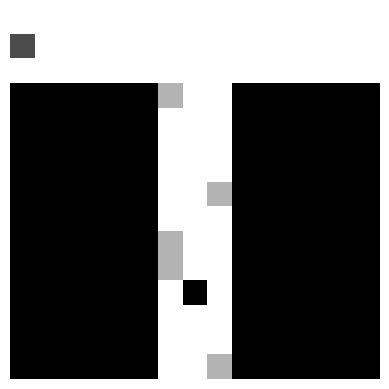

Row: 10 Col: 7 Reward: 0


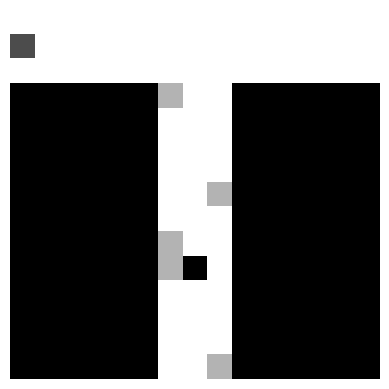

Row: 9 Col: 7 Reward: 1


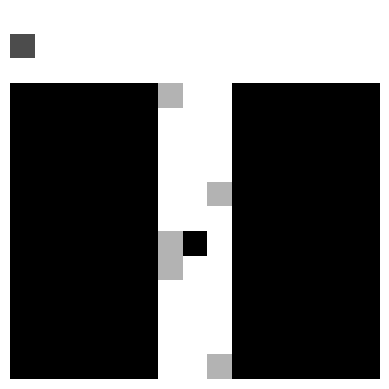

Row: 8 Col: 7 Reward: 1


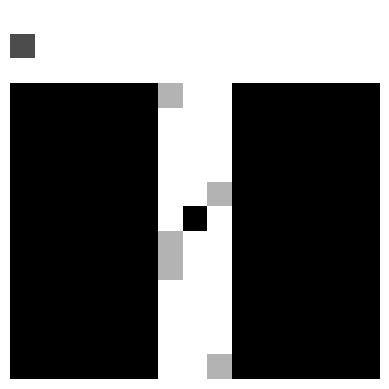

Row: 7 Col: 7 Reward: 0


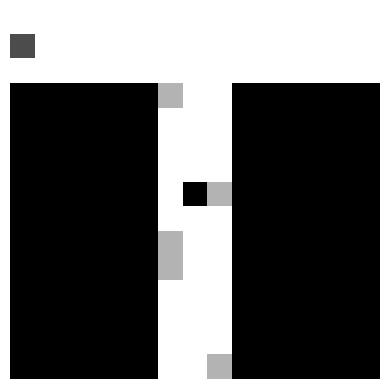

Row: 6 Col: 7 Reward: -1


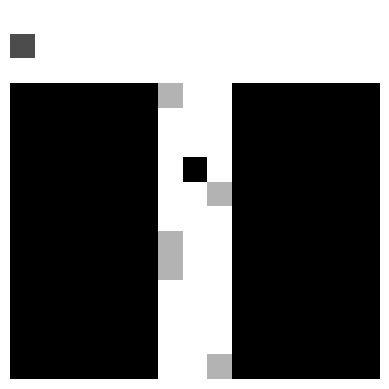

Row: 5 Col: 7 Reward: 0


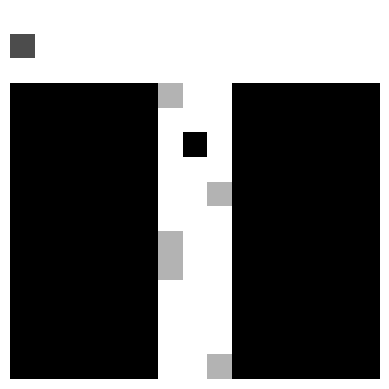

Row: 4 Col: 7 Reward: 0


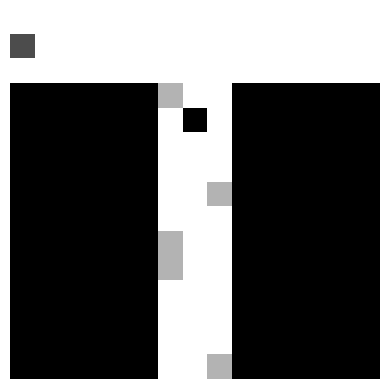

Row: 3 Col: 7 Reward: 0


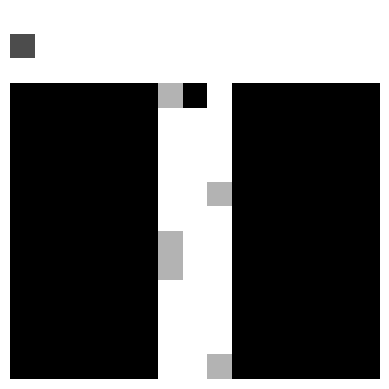

Row: 2 Col: 7 Reward: 1


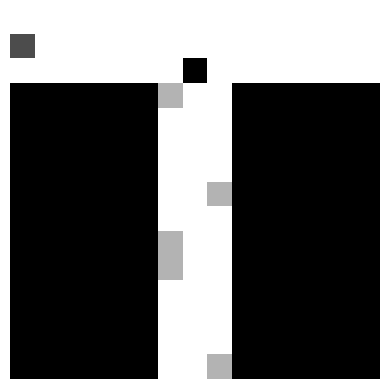

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


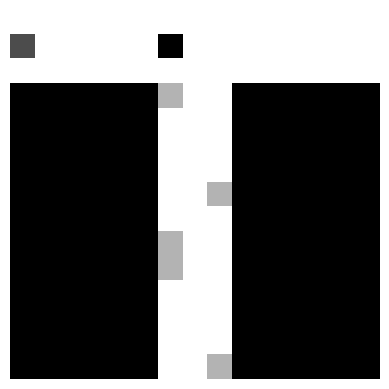

Row: 1 Col: 5 Reward: 0


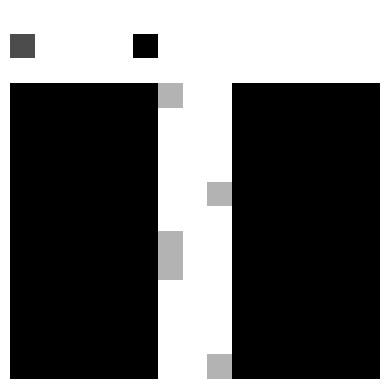

Row: 1 Col: 4 Reward: 0


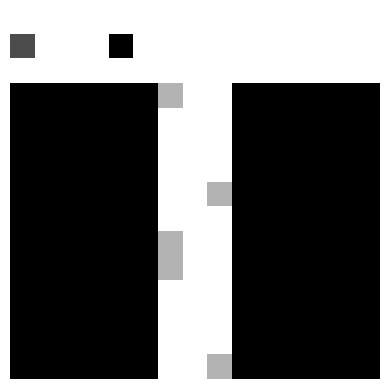

Row: 1 Col: 3 Reward: 0


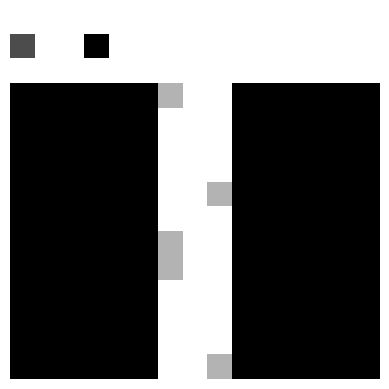

Row: 1 Col: 2 Reward: 0


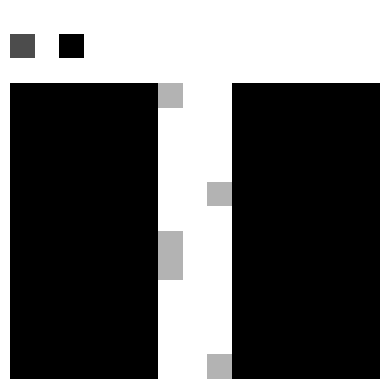

Row: 1 Col: 1 Reward: 0


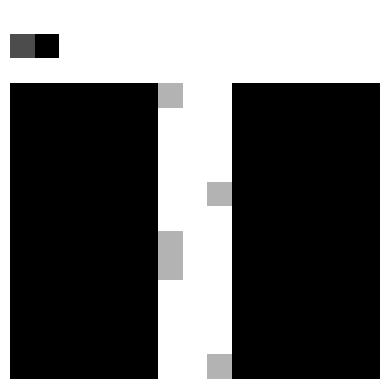

Row: 1 Col: 0 Reward: 5
Episode 4 completed.
Final Reward: 5


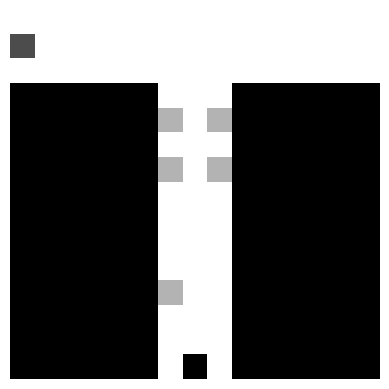

Row: 13 Col: 7 Reward: 0


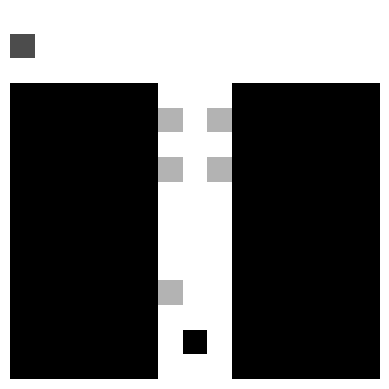

Row: 12 Col: 7 Reward: 0


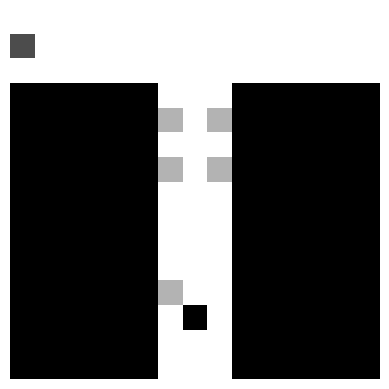

Row: 11 Col: 7 Reward: 0


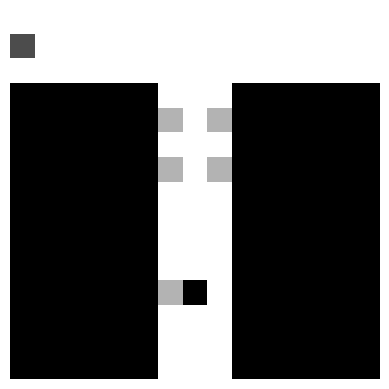

Row: 10 Col: 7 Reward: 1


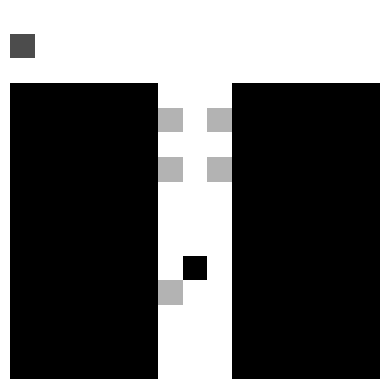

Row: 9 Col: 7 Reward: 0


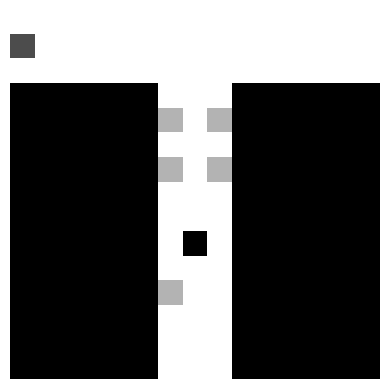

Row: 8 Col: 7 Reward: 0


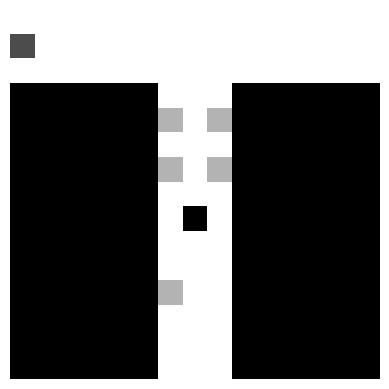

Row: 7 Col: 7 Reward: 0


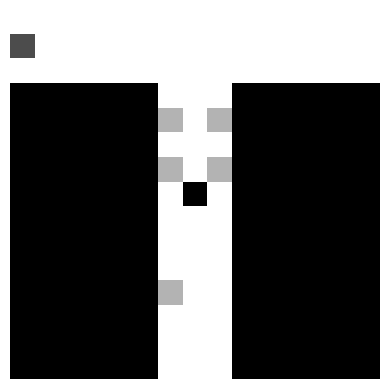

Row: 6 Col: 7 Reward: 0


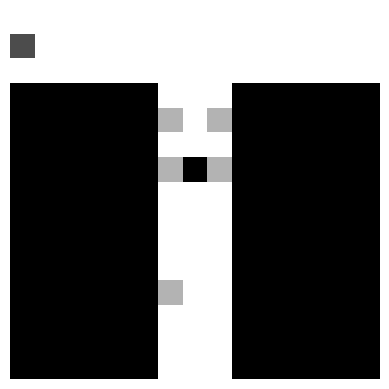

Row: 5 Col: 7 Reward: 0


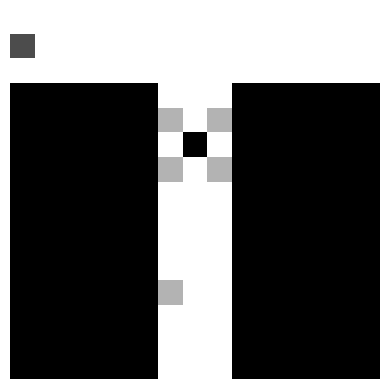

Row: 4 Col: 7 Reward: 0


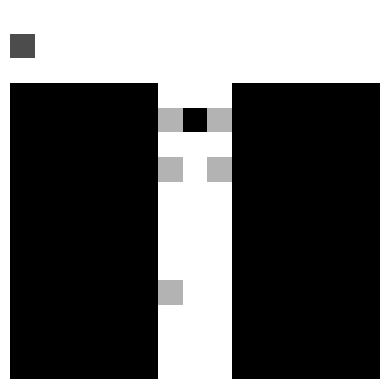

Row: 3 Col: 7 Reward: 0


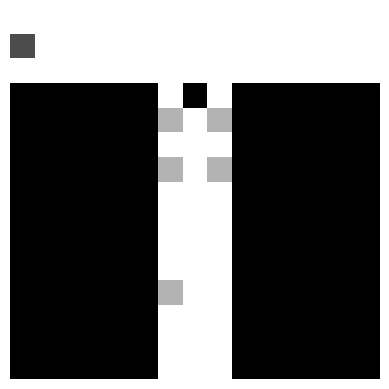

Row: 2 Col: 7 Reward: 0


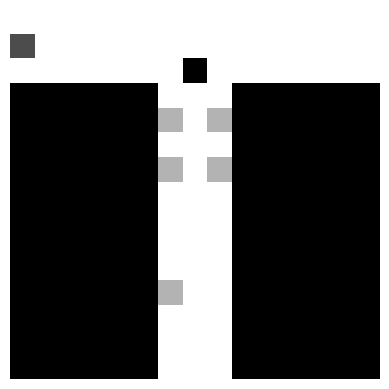

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


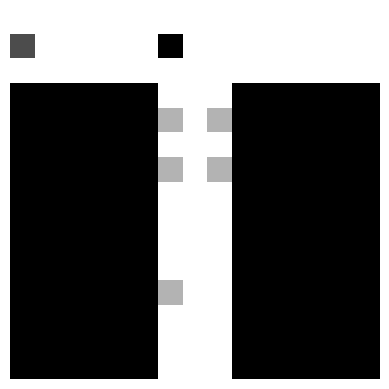

Row: 1 Col: 5 Reward: 0


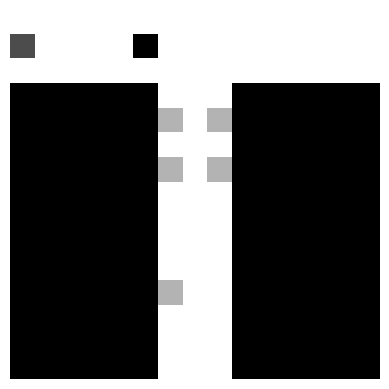

Row: 1 Col: 4 Reward: 0


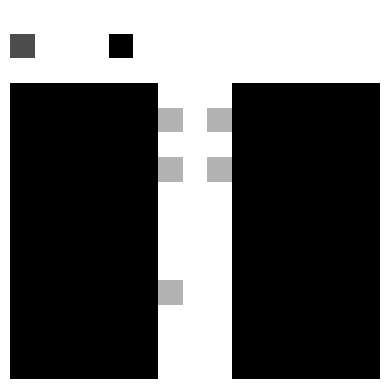

Row: 1 Col: 3 Reward: 0


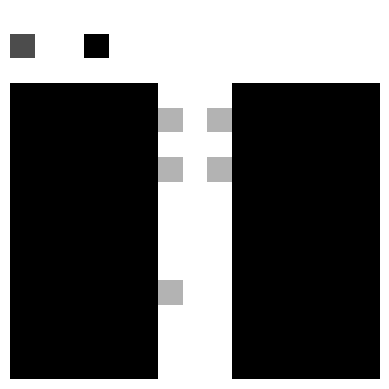

Row: 1 Col: 2 Reward: 0


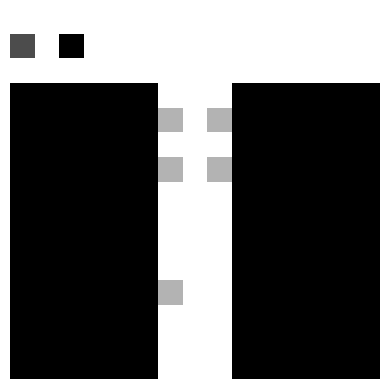

Row: 1 Col: 1 Reward: 0


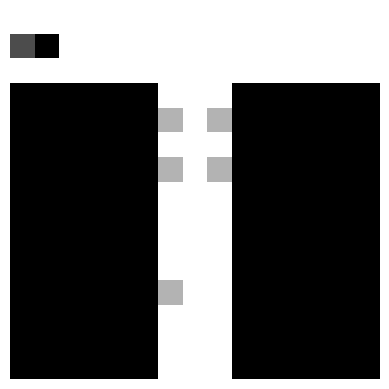

Row: 1 Col: 0 Reward: 5
Episode 5 completed.
Final Reward: 5
Total reward: 25


In [ ]:
env = TMazeEnv1()  # Initialize the environment with your grid
totalr = 0

for episode in range(5):  # Run 10 episodes
    observation = env.reset(rat=(14, 7), n_cues_left=3, n_cues_right=2)  # Reset the environment and set the rat at position (14, 7)
    done = False
    row = 14
    col = 7
    action=1
    while not done:
        env.render()
        if row == 2 and col == 7:
            print("Taking decision")
              # Render the current state of the environment
            action = env.action_space.sample()  # Choose a random action
            print("Action:", action)

        observation, row, col, reward, done = env.step(action)  # Take a step in the environment
        print("Row:", row, "Col:", col, "Reward:", reward)


    print("Episode", episode + 1, "completed.")
    print("Final Reward:", reward)
    totalr += reward

print("Total reward:", totalr)


##Q learning

####Overview of q learning

Q-learning is a reinforcement learning algorithm used to find the optimal policy for decision-making in an environment. It maintains a Q-table that stores the expected cumulative rewards for each state-action pair. The algorithm iteratively updates the Q-values based on observed rewards and the maximum Q-value of the next state. This process gradually converges to the optimal Q-values, enabling the agent to make informed decisions. The Q-values guide the agent's policy, determining the best actions to take in each state.

###How it works

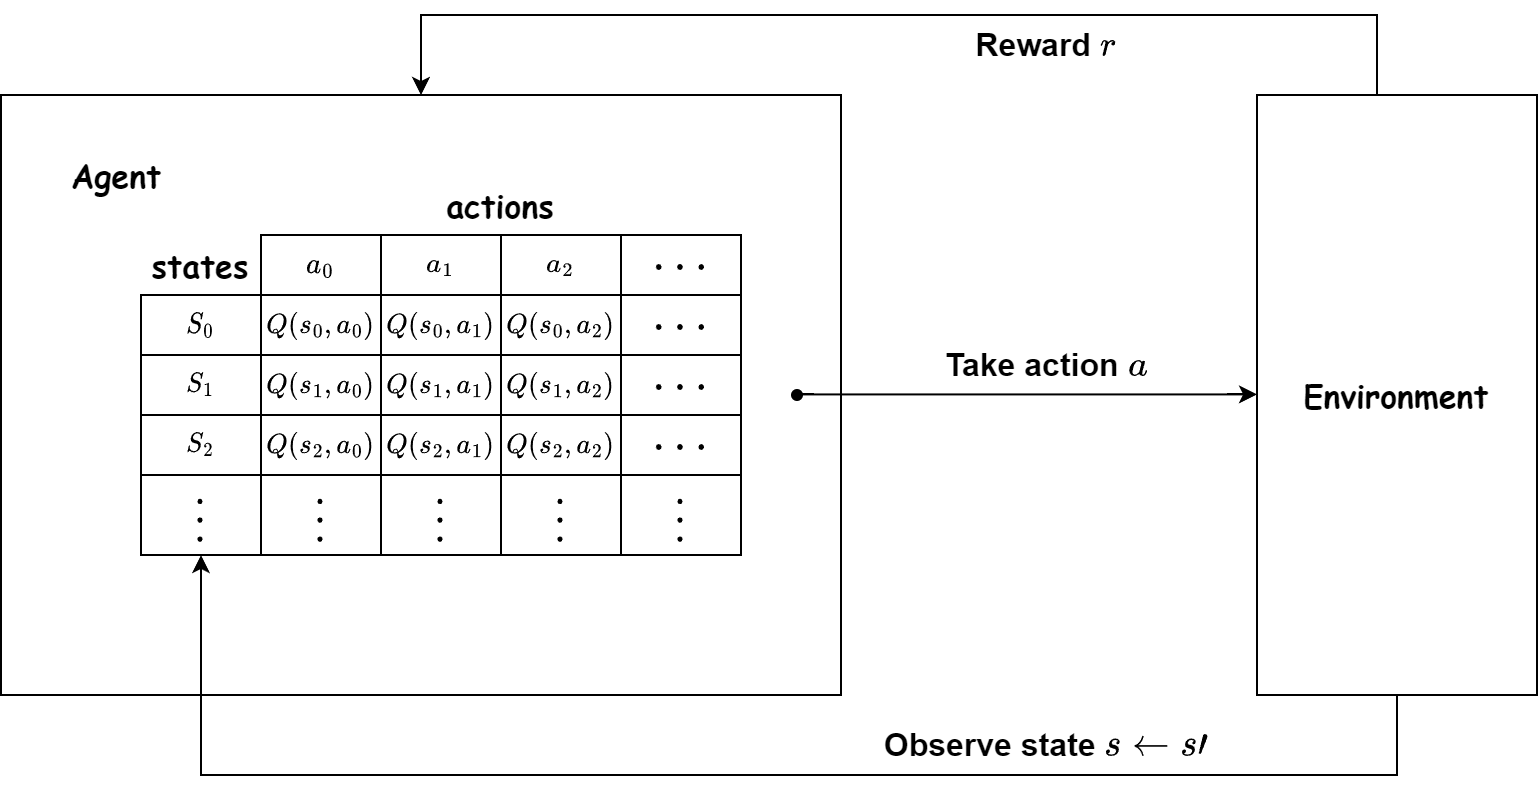


The Q-table is a tabular representation of the Q-values for each state-action pair in a reinforcement learning problem. It is updated during the Q-learning process. Each cell in the table represents the Q-value for a specific state-action pair. The Q-value represents the expected cumulative reward an agent can achieve by taking a particular action in a given state and following an optimal policy thereafter. The Q-table can be represented using LaTeX as follows:



Here, $Q(s,a)$ represents the Q-value for state $s$ and action $a$. For example, $Q(1,1)$ represents the Q-value for State 1 and Action 1.



###Epsilon-Greedy Policy:

The epsilon-greedy policy is a strategy used to balance exploration and exploitation in reinforcement learning. It determines how the agent selects actions based on the Q-values in the Q-table. The policy selects the action with the highest Q-value (exploitation) most of the time, but occasionally chooses a random action (exploration) to explore other possibilities.

The epsilon-greedy policy can be defined using the following equations:

\begin{equation*}
\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}, & \text{if } a = \text{argmax}_a Q(s,a) \
\frac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}
\end{cases}
\end{equation*}

Here, $\pi(a|s)$ represents the probability of selecting action $a$ in state $s$. $|\mathcal{A}|$ represents the total number of possible actions. The parameter $\epsilon$ controls the exploration-exploitation trade-off. If $a$ is the action with the highest Q-value, the probability of selecting $a$ is $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}$. Otherwise, the probability of selecting $a$ is $\frac{\epsilon}{|\mathcal{A}|}$.

The epsilon-greedy policy ensures that the agent mostly selects the action with the highest Q-value, but with a small probability $\epsilon$, it explores other actions by selecting them randomly.

###The relationship of q learning and dopamine


The theory and data available today indicate that the phasic activity of midbrain dopamine neurons encodes a reward prediction error used to guide learning throughout the frontal cortex and the basal ganglia. Activity in these dopaminergic neurons is now believed to signal that a subject's estimate of the value of current and future events is in error and indicate the magnitude of this error. This is a kind of combined signal that most scholars active in dopamine studies believe adjusts synaptic strengths in a quantitative manner until the subject's estimate of the value of current and future events is accurately encoded in the frontal cortex and basal ganglia



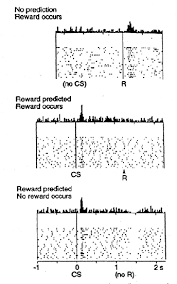

Knowing that lets now implement a q learning agent who uses an epsilon greedy strategy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action between 1 and 2
        return env.action_space.sample()
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q) +1

In [ ]:
num_episodes=100#thousand episodes is like stimulating a thousand neurons

# Define the TD learning parameters
alpha = 0.001  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.7  # Epsilon for epsilon-greedy strategy
decay_rate=0.95

In [ ]:
!apt install ffmpeg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_fluorescence_movie(fluorescence_traces):
    num_frames, num_neurons = fluorescence_traces.shape

    fig, axs = plt.subplots(num_neurons, 1, facecolor='black', figsize=(6, 8))
    axs = axs.flatten()

    def update(frame):
        for i, ax in enumerate(axs):
            ax.clear()
            ax.set_axis_off()
            ax.imshow(fluorescence_traces[frame, i].reshape(1, -1), cmap='hot')
            ax.set_title(f'Frame: {frame+1}, Neuron: {i+1}')

    animation = FuncAnimation(fig, update, frames=num_frames, interval=100)

    
    animation.save('/content/vids/fluorescence_movie1.mp4', writer='ffmpeg', dpi=100)



Lets first perform a fairly easy task where there is only a single cue on the right indicating the reward is on the right.We want to check the total cumulative reward and TD error for this task

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def run_episodes(n_cues_left, n_cues_right):
    Q = np.zeros(2)
    # Define the TD learning parameters
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor
    epsilon = 0.7  # Epsilon for epsilon-greedy strategy
    decay_rate=0.9

    # Initialize the variables for storing the average TD error for each step
    num_steps = 18  # Assuming a corridor length of 13 steps
    num_episodes = 50  # Set the number of episodes
    avg_td_errors = np.zeros(num_steps)
    td_errors1 = []
    td_error = 0#it will have memory of all previous td error s this makes sense
    tderror_tracker = np.zeros((19, num_episodes))
    reward = 0#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes 
    reward_t1 = []
    action_history1 = []
    action=0
    total_rewards=[]
    td_error = 0
    # Other code...

    for episode in range(num_episodes):
        # Reset the environment and set the rat at position (14, 7)
        observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
        done = False
        row = 14
        col = 7
        step = 0  # Track the step number
      
        
        reward_t1 = []
        td_errors1 = []
        episode_action_history = []  # Action history for the current episode
        total_reward=0
        while not done:
            # env.render()
            #print("step", step)
            # Check if the agent is at the decision-making state
            if row == 2 and col == 7:
                state = 0  # Map the decision-making state to state 0
                action = epsilon_greedy(Q, epsilon)  # Choose the action using epsilon-greedy strategy
                episode_action_history.append(action)  # Append action to the episode action history
            else:
                td_error = reward + gamma * np.max(Q) - Q[action - 1]
                reward = reward
            observation, row, col, reward, done = env.step(action)  # Take a step in the environment
            
            #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)
           
            td_error = reward + gamma * np.max(Q) - Q[action - 1]  # Calculate the TD error
            Q[action - 1] += alpha * td_error  # Update the Q-value for the current action
     
            
            td_errors1.append(td_error)  # Append the TD error to the list
            reward_t1.append(reward)
            action_history1.append(episode_action_history)
            rd_error = 0
            reward = 0
            step+=1
            # Increment the step count and accumulate the TD error for the corresponding step
            # Assuming the corridor is between rows 2 and 14

            # avg_td_errors[step - 1] += (td_error - avg_td_errors[step - 1])
            #print(Q)
        tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
        total_rewards.append(sum(reward_t1))
        epsilon*=decay_rate

    #print(tderror_tracker)

    # Calculate the average TD error for each step


    # Calculate the average TD error for each step
    avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
    avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
    print("TOTAL REWARD", np.sum(avg_error_per_episode))

    # Smooth the TD error data using a moving average
    window_size = 3  # Adjust the window size as desired
    smoothed_td_errors = np.convolve(avg_td_errors, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed TD error data
    plt.plot(range(len(avg_td_errors)), smoothed_td_errors, '-k')

    plt.xlabel('Step')
    plt.ylabel('TD Error')
    plt.title('Smoothed TD Error')
    plt.show()


    
    noise_level=0.1
    num_neurons = tderror_tracker.shape[0]
    gcamp_kernel = np.random.rand(num_neurons)
    fluorescence_episode = []
    delta_fluorescence_traces=[1]
    total_fluorescence_traces=[]
    ratio=[]
    
    delta_fluorescence_traces = []
    total_fluorescence_traces = []

    for i in range(tderror_tracker.shape[1]):
        spikes = tderror_tracker[:, i]
        fluorescence = np.convolve(spikes, gcamp_kernel, mode='same')
        noise = np.random.normal(0, tderror_tracker.shape[0])
        fluorescence_with_noise = fluorescence + noise

        delta_fluorescence = np.diff(fluorescence_with_noise)
        delta_fluorescence_traces.append(delta_fluorescence)
        total_fluorescence_traces.append(fluorescence_with_noise)

    # Plot the fluorescence traces
    window_size_f=2
    sum_f=np.sum(total_fluorescence_traces)
    plt.figure(figsize=(10, 6))
    for i in range(10):
        delta_fluorescence_trace = delta_fluorescence_traces[i]
        delta_fluorescence_trace1 = np.convolve(delta_fluorescence_trace, np.ones(window_size_f)/window_size_f, mode='same')
        #plt.plot(total_fluorescence_trace, label=f'Neuron {i+1} - Total')
        plt.plot(delta_fluorescence_trace1/sum_f, label=f'Neuron {i+1} ')

    plt.xlabel('Time')
    plt.ylabel('deltaF/F')
    plt.title('Simulated Fluorescence Traces')
    plt.legend()
    plt.show()

    #plot animation of gcamp activity




    # Create a figure with two subplots
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))

    # Plot the reward per step
    stepss = range(len(reward_t1))
    ax1.vlines(stepss, [0], reward_t1, colors='blue')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward per Step')

    # Plot the TD error per step

    ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('td error')
    ax2.set_title('TD Error per Step')


        # Plot the total reward per episode
    episodes = range(1, num_episodes + 1)
    ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Total Reward')
    ax3.set_title('Total Reward per Episode')

            # Plot the avg td error per episode
    episodes = range(1, num_episodes + 1)
    ax4.plot(episodes, avg_error_per_episode, linestyle='-')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('average td error')
    ax4.set_title('TD Error per Episode')

    # Adjust the layout to prevent overlapping of subplots
    plt.tight_layout()

    # Display the plot
    plt.show()









Here we can check the mouse's performance for different number of cues on each side

invalid action
invalid action
invalid action
invalid action
invalid action
TOTAL REWARD 4.070052355454629


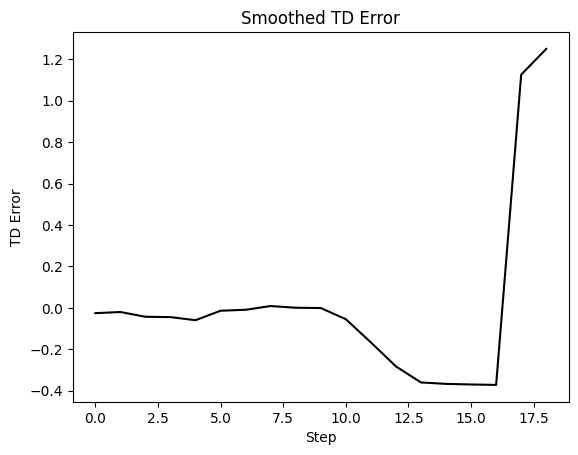

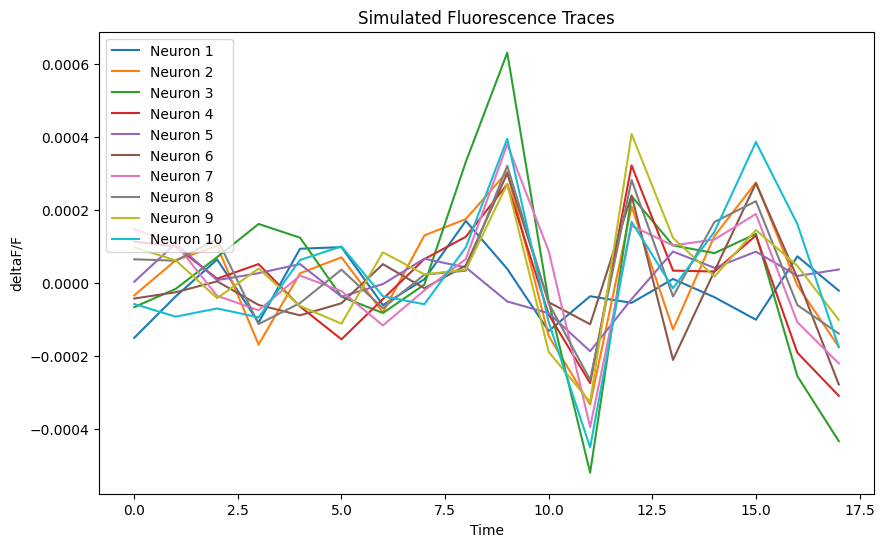

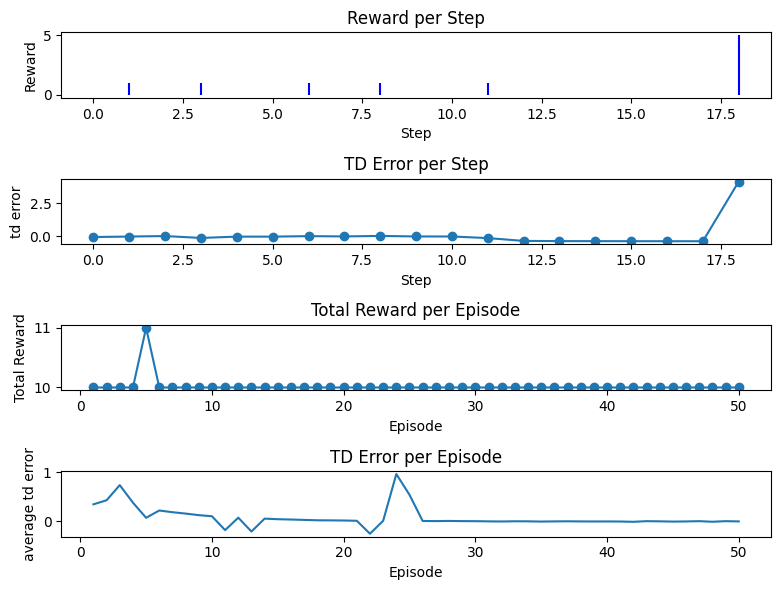

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 0
run_episodes(n_cues_left, n_cues_right)


invalid action
invalid action
invalid action
TOTAL REWARD 2.6997895022716434


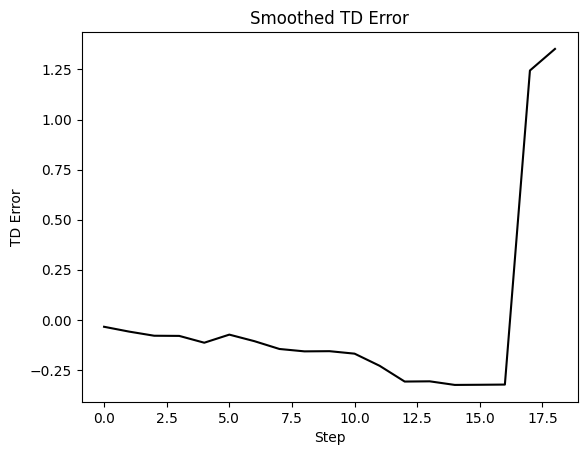

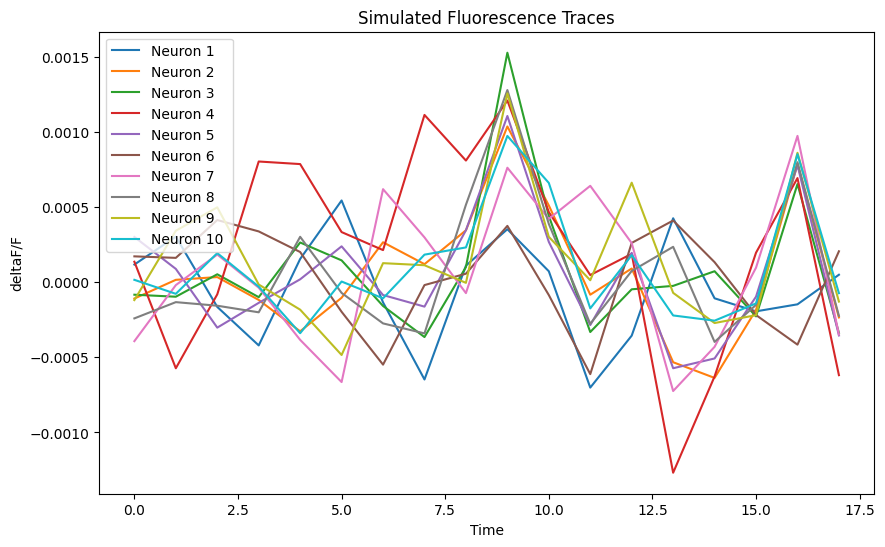

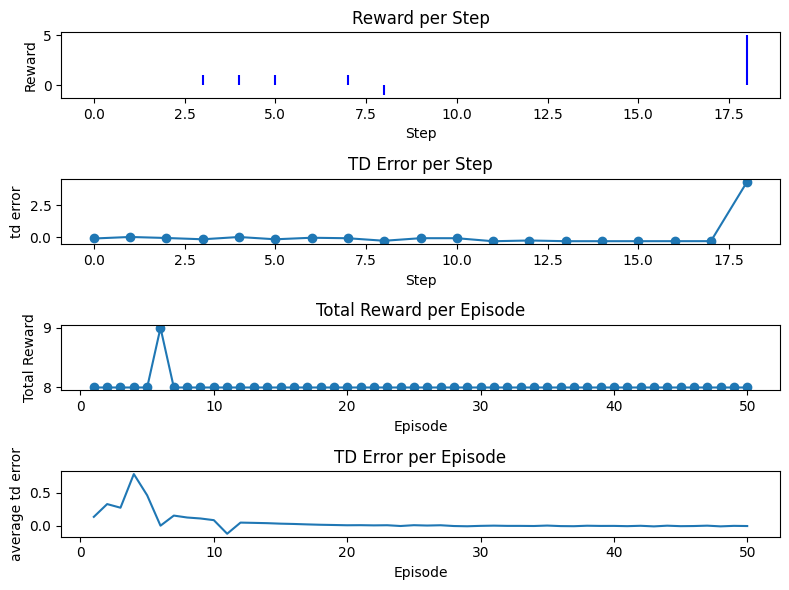

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 2
run_episodes(n_cues_left, n_cues_right)


invalid action
invalid action
invalid action
invalid action
TOTAL REWARD 2.8091337141769106


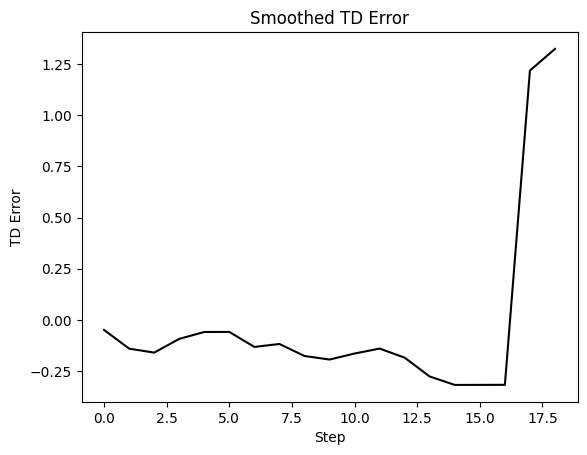

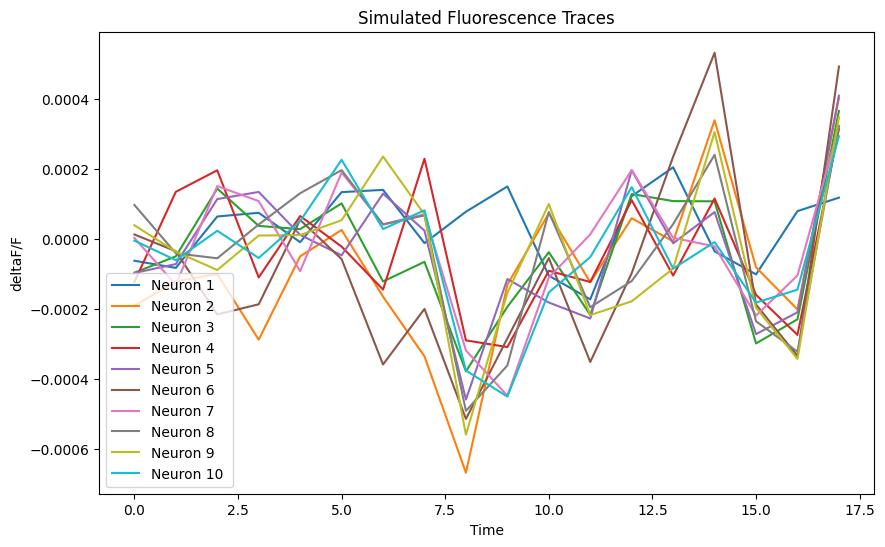

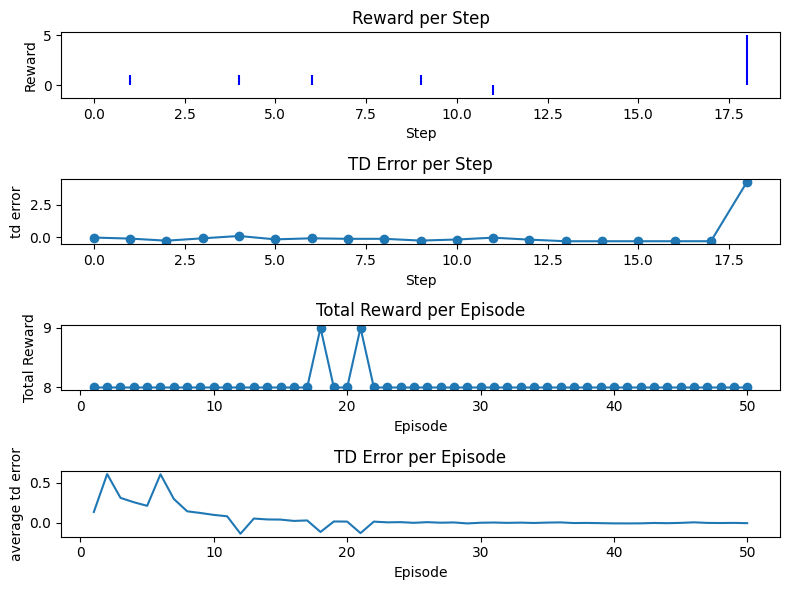

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 2
run_episodes(n_cues_left, n_cues_right)


invalid action
invalid action
invalid action
invalid action
TOTAL REWARD 1.932925366030621


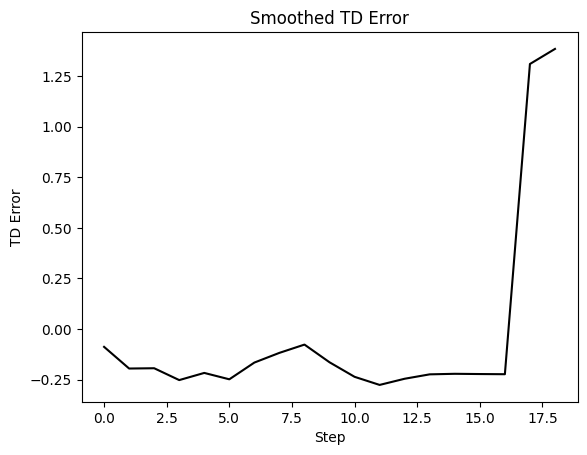

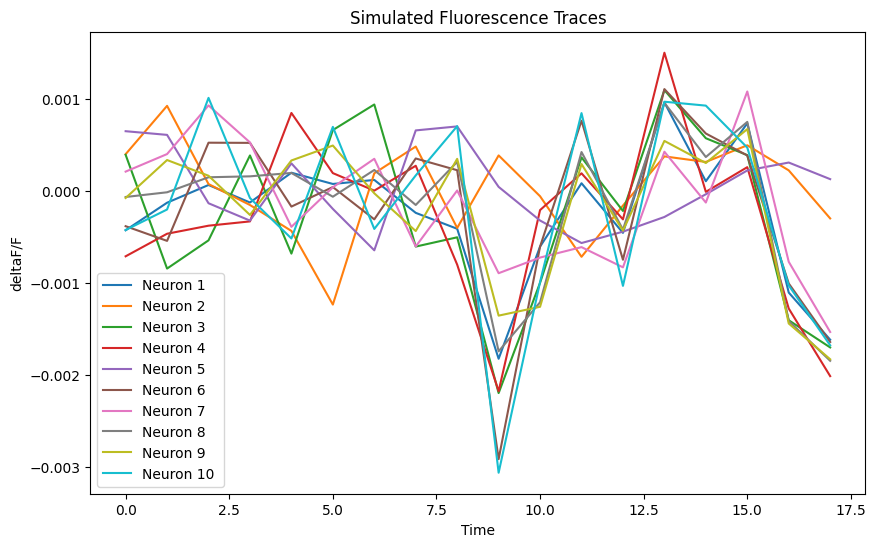

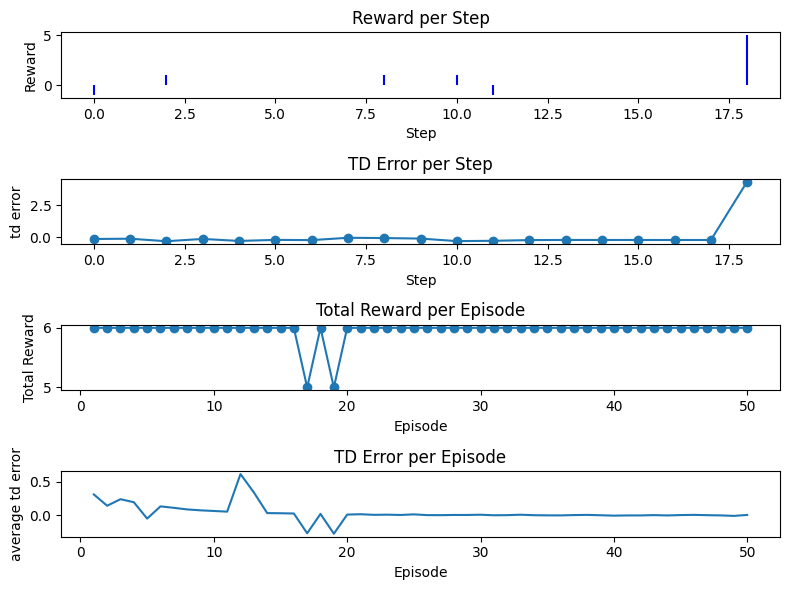

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 4
run_episodes(n_cues_left, n_cues_right)


invalid action
invalid action
invalid action
invalid action
TOTAL REWARD 2.161424372358111


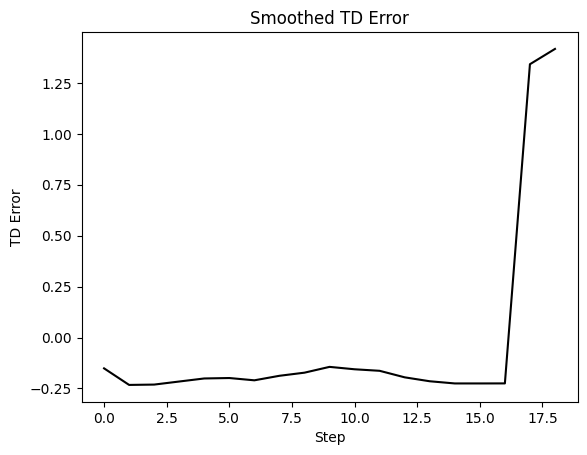

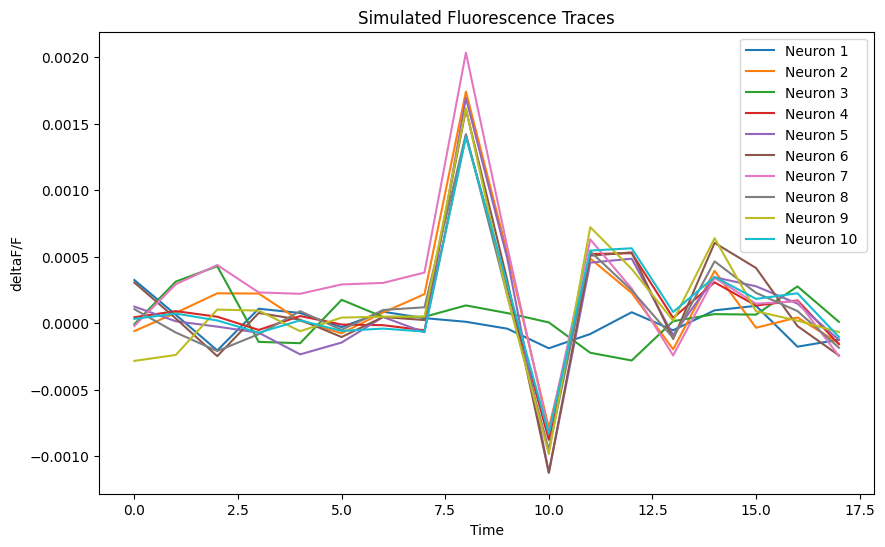

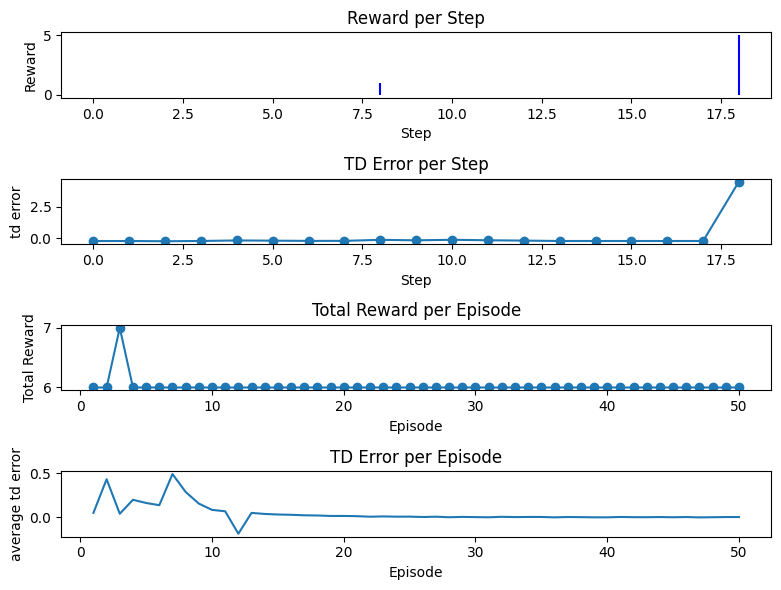

In [ ]:
# Example usage
n_cues_left = 1
n_cues_right = 0
run_episodes(n_cues_left, n_cues_right)

As we can see the flourocnet 